In [1]:
# Abigail Kelly
# Final Project
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.linalg import expm
PRECISION = np.double

In [2]:
# Arrays to hold results at t = 1
euler_results = []
extrap_results = []
explicit_results = []

Problem 1 (1-d)

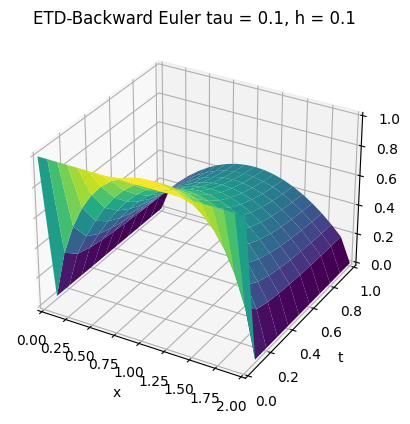

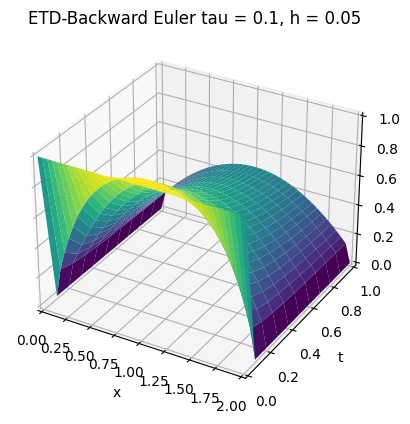

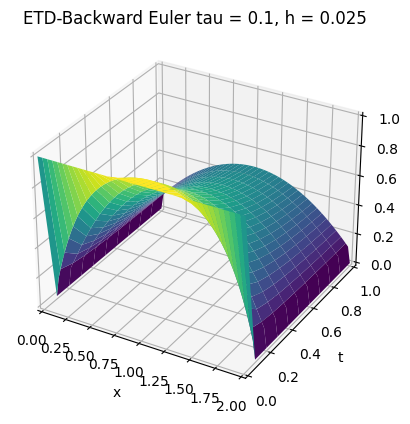

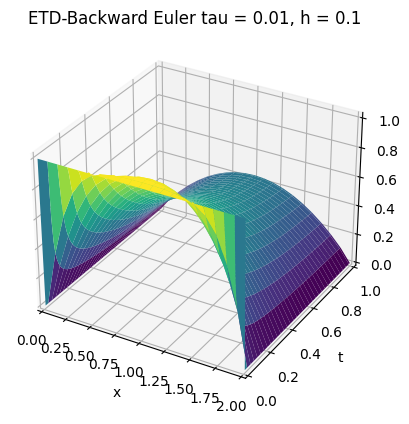

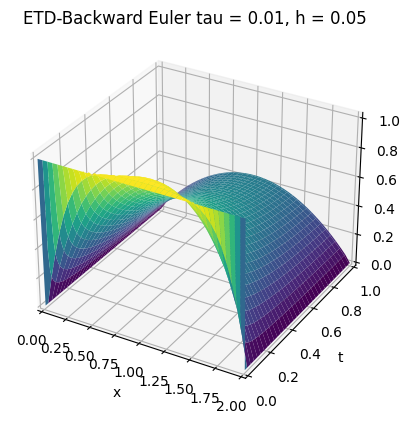

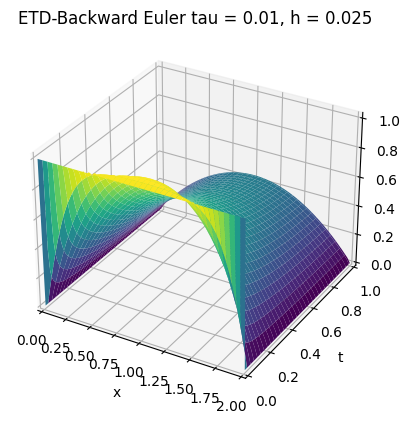

In [3]:
# Backward Euler Method
def q1_euler(max_x, dx, max_t, dt, flag = 0):
  M = int(max_x / dx) + 1
  N = int(max_t / dt) + 1
  r = dt / dx**2
  u = np.zeros((M,N))

  u[0, :] = 0.0  # Boundary condition at x=0
  u[-1, :] = 0.0  # Boundary condition at x=L
  u[:, 0] = 1.0  # Initial condition

  # Constructing the matrix A for the linear system
  A = np.zeros((M-2, M-2))
  np.fill_diagonal(A, 1 + 2*r)
  np.fill_diagonal(A[1:], -r)
  np.fill_diagonal(A[:, 1:], -r)

  b = np.zeros(M-2)

  # Iterating over time steps
  for j in range(0, N-1):
    b = u[1:-1, j]
    Fn = -1 / (1 + b)
    #b += dt * Fn
    b[0] += r * u[0, j+1]
    b[-1] += r * u[-1, j+1]
    u[1:-1, j+1] = np.linalg.solve(A, b)
    u[1:-1, j+1] -= dt * Fn

  if flag != 0:
    x = np.linspace(0, max_x, M)
    t = np.linspace(0, max_t, N)
    X, T = np.meshgrid(x, t)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f'ETD-Backward Euler tau = {dt}, h = {dx}')

    # Make sure the data is plotted against the correct axes
    ax.plot_surface(X, T, u.T, cmap='viridis')

    # Set the axis labels
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u')

    # Set the limits for each axis to start at 0
    ax.set_xlim([0, max_x])
    ax.set_ylim([0, max_t])
    ax.set_zlim([0, u.max()])
    #plt.savefig('1d_euler.eps', format='eps')
    plt.show()

  return u[:, -1]

tau = np.array([0.1, 0.01])
h = np.array([0.1, 0.05, 0.025])
max_t = 1
max_x = 2

for dt in tau:
  for dx in h:
    euler_results.append(q1_euler(max_x, dx, max_t, dt, 1))

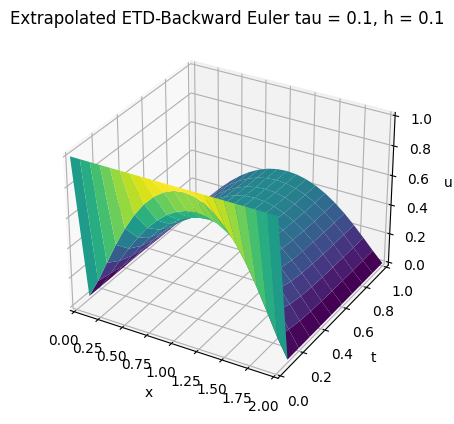

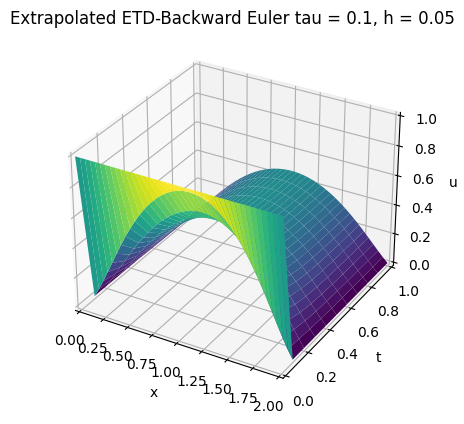

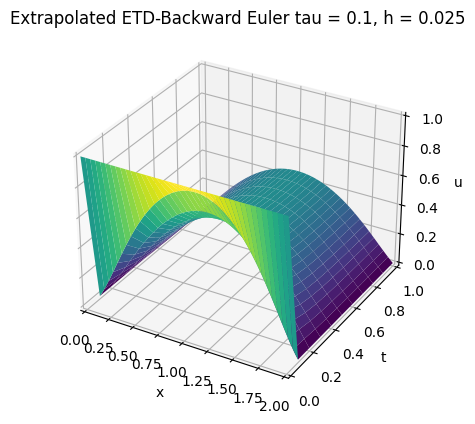

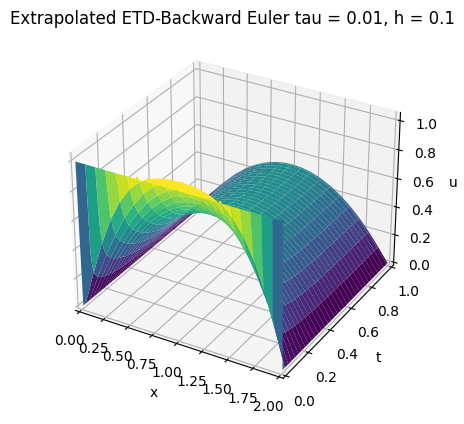

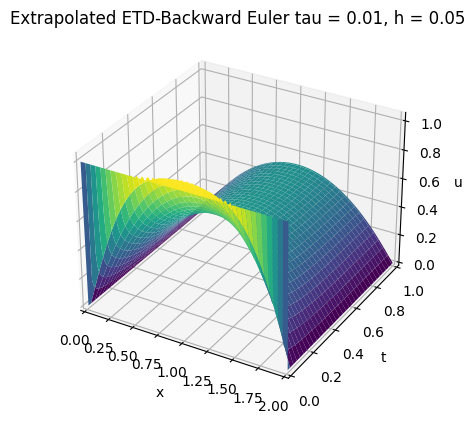

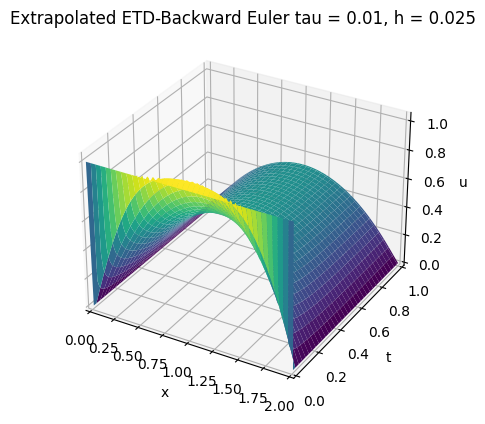

In [4]:
def q1_extrapolation(max_x, dx, max_t, dt, flag=0):
    M = int(max_x / dx) + 1
    N = int(max_t / dt) + 1
    r = dt / dx**2
    e = np.zeros((N, M))

    e[0, :] = 1  # initial condition

    # Define the tridiagonal matrix A
    A = np.zeros((M-2, M-2))
    np.fill_diagonal(A, -2)
    np.fill_diagonal(A[1:], 1)
    np.fill_diagonal(A[:, 1:], 1)

    # Define the matrices used for the LETD-BE scheme
    I = np.identity(M-2)
    v1 = np.linalg.inv(I - 2 * r * A)
    v2 = np.linalg.inv(I - r * A).dot(np.linalg.inv(I - r * A))
    v = 2 * v2 - v1

    # Time-stepping loop
    for j in range(0, N-1):
        u = e[j, 1:-1]
        Fn = -1 / (1 + u)  # Corrected the non-linear term calculation
        e[j + 1, 1:-1] = v.dot(u - 3 * dt * Fn)  # Update for next time step only

        # Apply boundary conditions
        e[j + 1, 0] = 0  # Left boundary
        e[j + 1, -1] = 0  # Right boundary

    # Plot the final result if flag is set
    if flag != 0:
      x = np.linspace(0, max_x, M)
      t = np.linspace(0, max_t, N)
      X, T = np.meshgrid(x, t)
      fig = plt.figure()
      ax = fig.add_subplot(111, projection='3d')
      ax.set_title(f'Extrapolated ETD-Backward Euler tau = {dt}, h = {dx}')
      ax.plot_surface(X, T, e, cmap='viridis')
      ax.set_xlabel('x')
      ax.set_ylabel('t')
      ax.set_zlabel('u')

      # Set the axis limits to ensure they start at 0
      ax.set_xlim([0, max_x])
      ax.set_ylim([0, max_t])
      ax.set_zlim([0, e.max()])
      #plt.savefig('1d_extrap.eps', format='eps')
      plt.show()

    return e[-1, :]

max_x = 2.0
max_t = 1.0
tau = np.array([0.1, 0.01])
h = np.array([0.1, 0.05, 0.025])

for dt in tau:
  for dx in h:
    extrap_results.append(q1_extrapolation(max_x, dx, max_t, dt, 1))

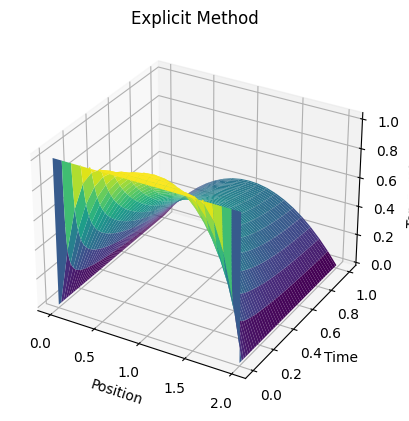

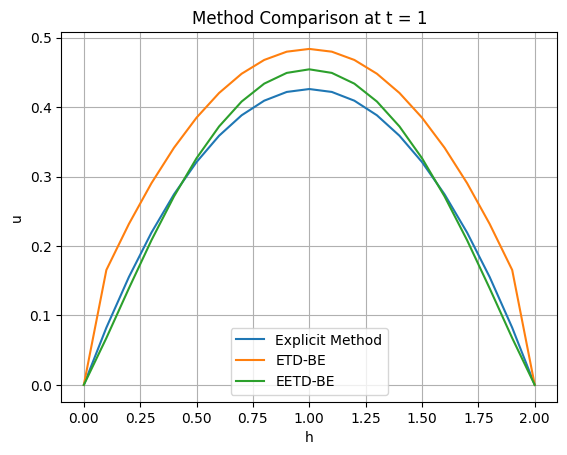

In [5]:
# Explicit Method
k = 0.001  # time step
h = 0.1  # spatial step
t_final = 1
x_final = 2

# Number of steps
M = int(t_final / k) + 1  # Time steps
N = int(x_final / h) + 1  # Spatial steps

# Stability parameter
r = 0.1

# Initialize solution matrix with initial condition
u = np.zeros((N, M))
u[:, 0] = 1

for j in range(0, M - 1):
    for i in range(1, N - 1):
        Fn = -1 / (1 + u[i, j])
        u[i, j + 1] = u[i, j] + r * (u[i - 1, j] - 2 * u[i, j] + u[i + 1, j]) - k*Fn

    # Apply zero boundary conditions
    u[0, j + 1] = 0
    u[-1, j + 1] = 0

explicit_results = u[:, -1].copy()

# Create grid for surface plot
x = np.linspace(0, x_final, N)
t = np.linspace(0, t_final, M)
X, T = np.meshgrid(x, t)

# Plot surface at final time step
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u.T, cmap='viridis')
ax.set_xlabel('Position')
ax.set_ylabel('Time')
ax.set_zlabel('Temperature')
ax.set_title('Explicit Method')
plt.show()

max_x = 2
max_t = 1
dx = 0.1
dt = 0.1
euler = q1_euler(max_x, dx, max_t, dt)
extrap = q1_extrapolation(max_x, dx, max_t, dt)

# Plot 1D graph at final time step
plt.plot(np.linspace(0, x_final, N), u[:, -1], label='Explicit Method')
plt.plot(np.linspace(0, x_final, N), euler, label='ETD-BE')
plt.plot(np.linspace(0, x_final, N), extrap, label='EETD-BE')
plt.xlabel('h')
plt.ylabel('u')
plt.title('Method Comparison at t = 1')
plt.grid(True)
plt.legend()
plt.savefig('method_comparison.eps', format='eps')
plt.show()

In [6]:
# Find the spatial stamps that explicit has in common with the numerical solutions
euler_errors = []
extrap_errors = []

# h = 0.1, tau = 0.1: the three methods will share all the time steps
euler_errors.append(1.0 * np.linalg.norm(explicit_results - euler_results[0], ord=np.inf)/1)
extrap_errors.append(0.1 * np.linalg.norm(explicit_results - extrap_results[0], ord=np.inf))

# h = 0.05, tau = 0.1: get matching steps for numerical solutions
euler_temp = []
extrap_temp = []
for i in range(0, len(euler_results[1]), 2):
  euler_temp.append(euler_results[1][i])
  extrap_temp.append(extrap_results[1][i])

euler_errors.append(1.0 * np.linalg.norm(explicit_results - euler_temp, ord=np.inf))
extrap_errors.append(0.1 * np.linalg.norm(explicit_results - extrap_temp, ord=np.inf))

# h = 0.025, tau = 0.1; get matching steps for numerical solutions
euler_temp = []
extrap_temp = []
for i in range(0, len(euler_results[2]), 4):
  euler_temp.append(euler_results[2][i])
  extrap_temp.append(extrap_results[2][i])

euler_errors.append(1.0 * np.linalg.norm(explicit_results - euler_temp, ord=np.inf))
extrap_errors.append(0.1 * np.linalg.norm(explicit_results - extrap_temp, ord=np.inf))


# print the errors
print(f'                             L inf Errors')
print(f'                               tau = 0.1')
print(f'Method                h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Backward-Difference   {euler_errors[0]:.2e}  {euler_errors[1]:.2e}   {euler_errors[2]:.2e}')
print(f'Extrapolation         {extrap_errors[0]:.2e}  {extrap_errors[1]:.2e}   {extrap_errors[2]:.2e}')

                             L inf Errors
                               tau = 0.1
Method                h = 0.1   h = 0.05   h = 0.025
-----------------------------------------------------------------------------------------
Backward-Difference   8.31e-02  8.31e-02   8.31e-02
Extrapolation         2.84e-03  2.86e-03   2.86e-03


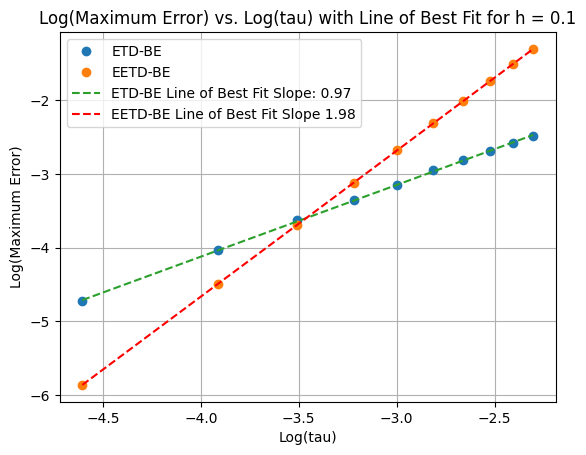

In [7]:
tau = np.arange(0.01, 0.11, 0.01)
dx = 0.1
max_x = 2
max_t = 1
# produced errors to save on runtime
error_euler = [0.008886601579936981, 0.017625451812867246, 0.026444710641659916, 0.03469737265231755, 0.043042075614997025, 0.05217548678864774,
               0.05981602769418272, 0.06827891666544479, 0.0754803616296983, 0.08305217113528253]
error_extrap = [0.00284, 0.0112036, 0.02500451, 0.04419744, 0.06875099, 0.09864108, 0.13384818, 0.17435585, 0.22014991, 0.27121789]

log_tau = np.log(tau)
log_errors_BE = np.log(error_euler)
log_errors_LOD = np.log(error_extrap)

plt.figure()
# Generate plot with log-log scale and line of best fit
plt.plot(log_tau, log_errors_BE, marker='o', linestyle='', label='ETD-BE')
plt.plot(log_tau, log_errors_LOD, 'o', label='EETD-BE')

# Perform linear regression to find the slope (order of convergence)
slope_BE, intercept_BE, _, _, _ = linregress(log_tau, log_errors_BE)
slope_LOD, intercept_LOD, _, _, _ = linregress(log_tau, log_errors_LOD)

plt.plot(log_tau, intercept_BE + slope_BE * log_tau, '--', label=f'ETD-BE Line of Best Fit Slope: {slope_BE:.2f}')
plt.plot(log_tau, intercept_LOD + slope_LOD * log_tau, 'r--', label=f'EETD-BE Line of Best Fit Slope {slope_LOD:.2f}')

plt.xlabel('Log(tau)')
plt.ylabel('Log(Maximum Error)')
plt.title(f'Log(Maximum Error) vs. Log(tau) with Line of Best Fit for h = {dx}')
plt.legend()
plt.grid(True)
plt.savefig('loglogplot_1d.eps', format='eps')
plt.show()

Problem 2 (2-d)

In [8]:
# Arrays to hold results at t = 1
euler_results = []
extrap_results = []
explicit_results = []

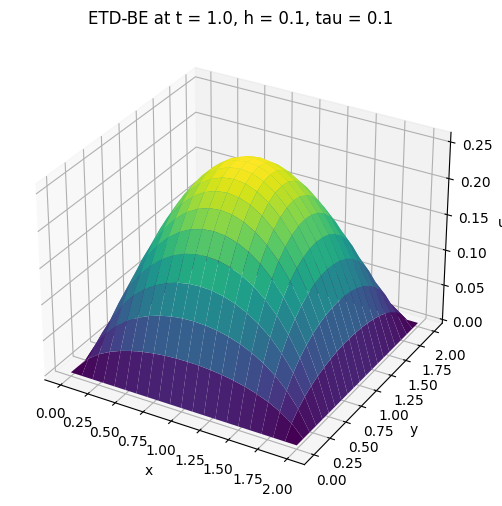

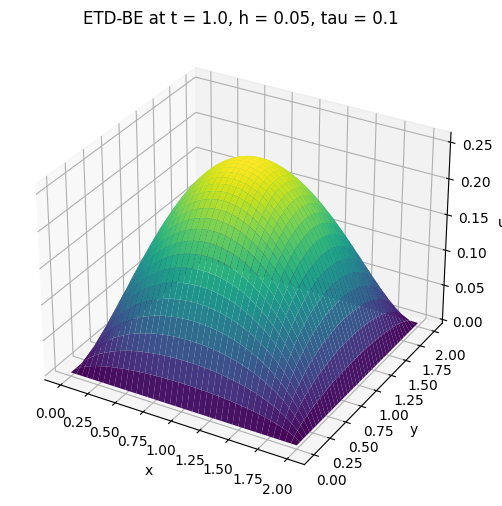

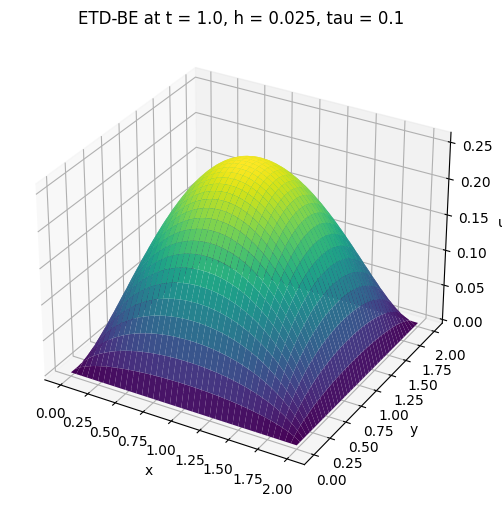

In [9]:
# Backward Euler
def etd_be_2d(max_xy, dxy, max_t, dt, flag=0):
  M = int(max_xy / dxy) - 1  # Number of grid points in y-direction
  N = int(max_xy / dxy) - 1 # Number of grid points in x-direction
  r = dt / dxy**2
  time_steps = int(max_t / dt) + 1 # Number of time stamps

  # [time, x, y]
  U = np.zeros((time_steps, M + 2, N + 2))

  # set the initial condition
  y = 0
  for i in range(N + 2):
    y = i * dxy
    for j in range(M + 2):
      U[0, i, j] = np.sin(np.pi * y / 2)

  # set the boundary conditions (when x, y = 0 = T)
  U[:, :, 0] = 0
  U[:, :, -1] = 0
  U[:, 0, :] =  0
  U[:, -1, :] = 0

  # Create matrix A
  A = np.zeros((M * N, M * N))
  np.fill_diagonal(A, -4)
  np.fill_diagonal(A[1:], 1)
  np.fill_diagonal(A[:, 1:], 1)
  np.fill_diagonal(A[M:], 1)
  np.fill_diagonal(A[:, M:], 1)

  # Add the scattered 0s on the diagonals right above and below the main diagonal
  for i in range(1, M):
    x_idx = i * N - 1
    y_idx = i * N
    A[x_idx, y_idx] = 0
    A[y_idx, x_idx] = 0

  # Calculate B = I - rA
  I = np.identity(M * N)
  B = I - r * A

  # Time-stepping loop
  for t in range(time_steps - 1):
      U_flat = U[t, 1:-1, 1:-1].flatten()
      # Compute the nonlinear term, reshaped to a flat array
      Fn_flat = -1 / (1 + U_flat)
      # Solve the linear system B U_{n+1} = U_flat + dt * Fn_flat
      U[t + 1, 1:-1, 1:-1] = np.linalg.solve(B, U_flat - dt * Fn_flat).reshape((M, N))

  # Plot the final result
  fig = plt.figure(figsize=(8, 6))
  ax = fig.add_subplot(111, projection='3d')
  x = np.linspace(0, max_xy, N + 2)
  y = np.linspace(0, max_xy, M + 2)
  X, Y = np.meshgrid(x, y)
  ax.plot_surface(X, Y, U[-1, :, :], cmap='viridis')
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('u')
  plt.title(f'ETD-BE at t = {max_t}, h = {dxy}, tau = {dt}')
  #plt.savefig('2d_euler.eps')
  plt.show()

  # Return the final state
  final_state = U[-1, :, :]
  return final_state

max_x = 2.0
max_t = 1.0
# takes forever to run if tau = 0.01
tau = np.array([0.1])
h = np.array([0.1, 0.05, 0.025])

for dt in tau:
  for dx in h:
    euler_results.append(etd_be_2d(max_x, dx, max_t, dt, 1))

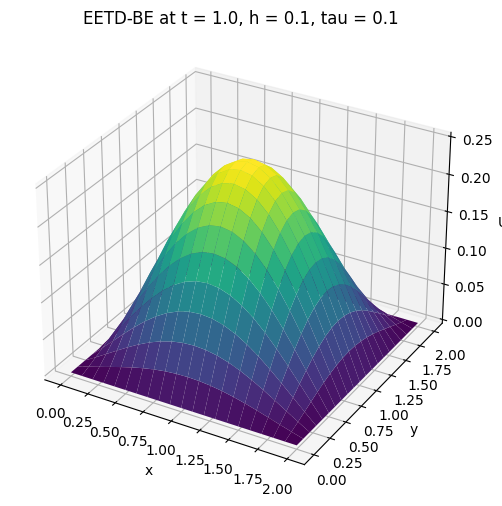

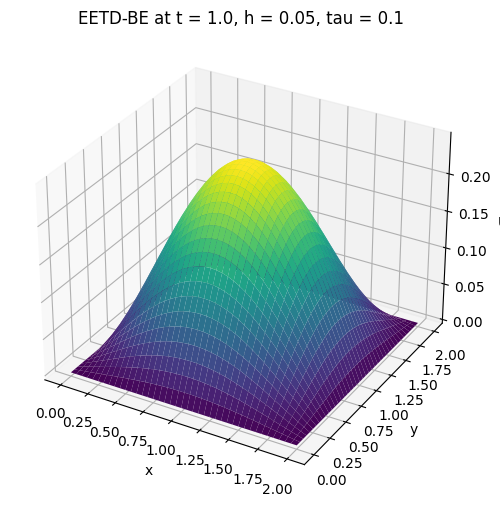

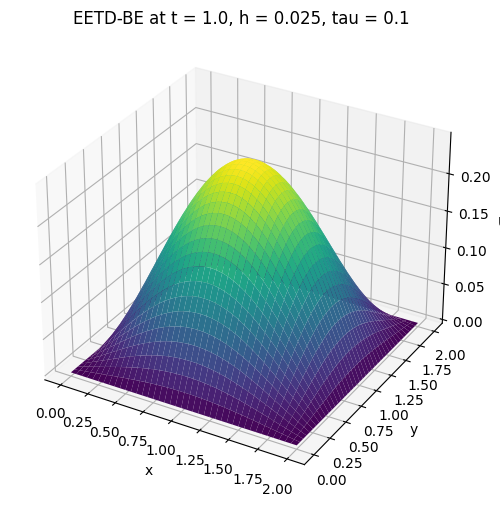

In [10]:
def extrap_etd_2d(max_xy, dxy, max_t, dt, flag=0):
    M = int(max_xy / dxy) - 1  # Number of grid points in y-direction
    N = int(max_xy / dxy) - 1  # Number of grid points in x-direction
    r = dt / dxy**2  # This remains the same
    time_steps = int(max_t / (2*dt))  # Half the number of time steps, each step is 2*dt

    # [time, x, y]
    U = np.zeros((time_steps + 1, M + 2, N + 2))  # Only need time_steps + 1 because of the 2*dt step

    # Set the initial condition
    for i in range(N + 2):
        y = i * dxy
        for j in range(M + 2):
            U[0, i, j] = np.sin(np.pi * y / 2)

    # Set the boundary conditions (when x, y = 0 or max_xy)
    U[:, :, 0] = U[:, :, -1] = U[:, 0, :] = U[:, -1, :] = 0

    # Create matrix A
    A = np.zeros((M * N, M * N))
    np.fill_diagonal(A, -4)
    np.fill_diagonal(A[1:], 1)
    np.fill_diagonal(A[:, 1:], 1)
    np.fill_diagonal(A[M:], 1)
    np.fill_diagonal(A[:, M:], 1)

    # Modify the diagonals to account for the 2D nature of A
    for i in range(1, M):
        A[i * N - 1, i * N] = A[i * N, i * N - 1] = 0

    # Calculate B1 = I - rA and B2 = I - 2rA for LETD-BE
    I = np.identity(M * N)
    B1 = I - r * A
    B2 = I - 2 * r * A

    # Time-stepping loop
    for t in range(time_steps):
        # Flatten the grid for matrix multiplication, excluding boundaries
        U_flat = U[t, 1:-1, 1:-1].flatten()

        # Compute the nonlinear term for the prediction and correction step
        Fn_flat_pred = -1 / (1 + U_flat)
        Fn_flat_corr = -1 / (1 + U_flat)

        # Prediction step
        U_pred_flat = np.linalg.solve(B1, U_flat - dt * Fn_flat_pred)

        # Correction step
        U_corr_flat = np.linalg.solve(B2, U_flat - 4 * dt * Fn_flat_corr)

        # Extrapolation step to get U(t_n + 2*dt)
        U[t + 1, 1:-1, 1:-1] = 2 * np.reshape(U_pred_flat, (M, N)) - np.reshape(U_corr_flat, (M, N))

        # Apply boundary conditions
        U[t + 1, :, 0] = U[t + 1, :, -1] = U[t + 1, 0, :] = U[t + 1, -1, :] = 0

    # Plot the final result if flag is set
    if flag != 0:
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        x = np.linspace(0, max_xy, N + 2)
        y = np.linspace(0, max_xy, M + 2)
        X, Y = np.meshgrid(x, y)
        ax.plot_surface(X, Y, U[-1, :, :], cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('U')
        plt.title(f'EETD-BE at t = {max_t}, h = {dxy}, tau = {dt}')
        #plt.savefig('2d_extrap.eps')
        plt.show()

    # Return the final state
    return U[-1, :, :]

max_x = 2.0
max_t = 1.0
# takes forever to run if tau = 0.01
tau = np.array([0.1])
h = np.array([0.1, 0.05, 0.025])

for dt in tau:
  for dx in h:
    extrap_results.append(extrap_etd_2d(max_x, dx, max_t, dt, flag = 1))

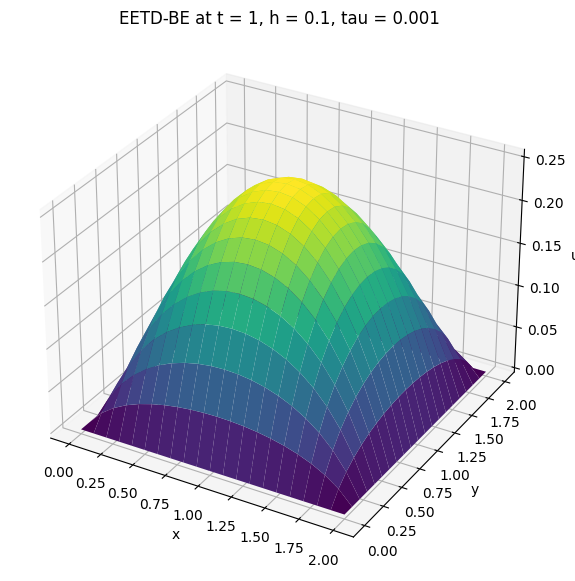

In [11]:
# Parameters
k = 0.001  # time step
h = 0.1    # spatial step
t_final = 1
x_final = 2
y_final = 2

# Number of steps
M = int(t_final / k) + 1  # Time steps
Nx = int(x_final / h) + 1  # Spatial steps in x
Ny = int(y_final / h) + 1  # Spatial steps in y

# Stability parameter
r = 0.1

# Initialize solution matrix with initial condition
u = np.zeros((Nx, Ny, M))
u[:, :, 0] = 1  # initial condition: u(x, y, 0) = 1 for all x, y

for j in range(M - 1):
    for i in range(1, Nx - 1):
        for l in range(1, Ny - 1):
            # Reaction term
            Fn = -1 / (1 + u[i, l, j])

            # Update the value of u at the next time step
            u[i, l, j + 1] = u[i, l, j] + r * (u[i - 1, l, j] + u[i + 1, l, j] + u[i, l - 1, j] + u[i, l + 1, j] - 4 * u[i, l, j]) - k * Fn

    # Apply zero boundary conditions at the spatial boundaries
    u[0, :, j + 1] = 0
    u[-1, :, j + 1] = 0
    u[:, 0, j + 1] = 0
    u[:, -1, j + 1] = 0

# Extract the final time step results
explicit_results = u[:, :, -1].copy()

# Create a surface plot for the results at t = 1
x = np.linspace(0, x_final, Nx)
y = np.linspace(0, y_final, Ny)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, u[:, :, -1], cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('u')
ax.set_title(f'EETD-BE at t = {t_final}, h = {h}, tau = {k}')
plt.show()

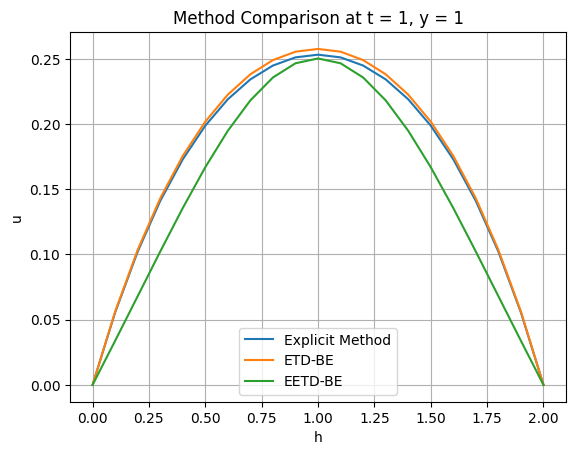

In [12]:
# plot a slice
plt.plot(np.linspace(0, x_final, N), explicit_results[:, 10], label='Explicit Method')
plt.plot(np.linspace(0, x_final, N), euler_results[0][:, 10], label='ETD-BE')
plt.plot(np.linspace(0, x_final, N), extrap_results[0][:, 10], label='EETD-BE')
plt.xlabel('h')
plt.ylabel('u')
plt.title('Method Comparison at t = 1, y = 1')
plt.grid(True)
plt.legend()
plt.savefig('method_comparison_2d.eps', format='eps')
plt.show()

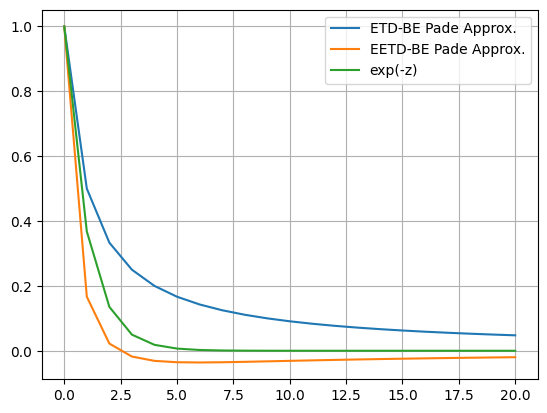

In [13]:
# (0,1)-Pade Approximation Graph for Presentation
pade_euler = []
pade_extrap = []
exp = []
for z in range(21):
  pade_euler.append(1 / (1 + z))
  pade_extrap.append((2 / (1 + z)**2) - (1 / (1 + 2 * z)))
  exp.append(np.exp(-z))

z = np.arange(0, 21, 1)
plt.plot(z, pade_euler, label='ETD-BE Pade Approx.')
plt.plot(z, pade_extrap, label="EETD-BE Pade Approx.")
plt.plot(z, exp, label="exp(-z)")
plt.legend()
plt.grid(True)
plt.savefig('pade_approx.eps', format='eps')
plt.show()